<a href="https://colab.research.google.com/github/LOKESH-GADEPALLI/melanoma_Assignment/blob/main/GADEPALLI_LOKESH_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow

## Importing all Libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import random
from glob import glob
import keras
from keras.models import Model

In [ ]:
tf.__version__

'2.17.0'

## Defining the path for train and test images

In [ ]:

Train_dp = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
Test_dp = "Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
data_dir_train = pathlib.Path(Train_dp)
data_dir_test = pathlib.Path(Test_dp)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Loading data using keras

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_dp,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Dataset for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_dp,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=30,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

## Visualize

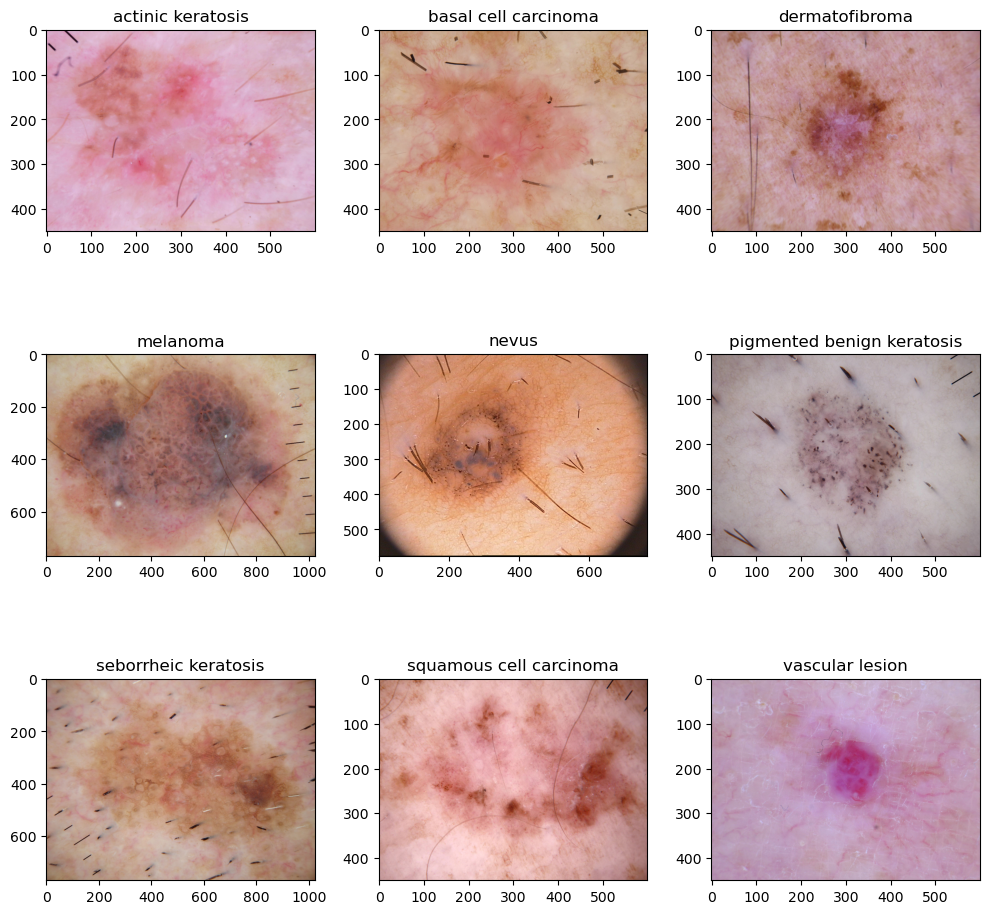

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    filenames = os.listdir(os.path.join(Train_dp, class_names[i]))
    image = Image.open(os.path.join(Train_dp, class_names[i],random.choice(filenames) ))

    ax.imshow(np.asarray(image).astype("uint8"))
    ax.set_title(class_names[i])

plt.tight_layout()
plt.show()

In [ ]:
# Validate dimentions of input and labels for one batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.016503267 0.85637265


###  Build model 1

In [ ]:

num_classes = 9

model_v1 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile
model_v1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    63,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,518,185 (246.12 MB)

 Trainable params: 64,518,185 (246.12 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model 1

In [ ]:

epochs = 20
history = model_v1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 837ms/step - accuracy: 0.2171 - loss: 2.2883 - val_accuracy: 0.3199 - val_loss: 1.8061
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 799ms/step - accuracy: 0.3620 - loss: 1.6948 - val_accuracy: 0.4810 - val_loss: 1.5412
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 790ms/step - accuracy: 0.4574 - loss: 1.4954 - val_accuracy: 0.5101 - val_loss: 1.4181
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 790ms/step - accuracy: 0.5293 - loss: 1.3294 - val_accuracy: 0.5213 - val_loss: 1.4081
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 791ms/step - accuracy: 0.5414 - loss: 1.2695 - val_accuracy: 0.5391 - val_loss: 1.4649
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 792ms/step - accuracy: 0.5643 - loss: 1.2126 - val_accuracy: 0.5101 - val_loss: 1.4277
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - accuracy: 0.5734 - loss: 1.1411 - val_accuracy: 0.5213 - val_loss: 1.4579
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 800ms/step - accuracy: 0.6533 - loss: 0.9432 - val_accu

### Visulaise the Accuracy for Model 1

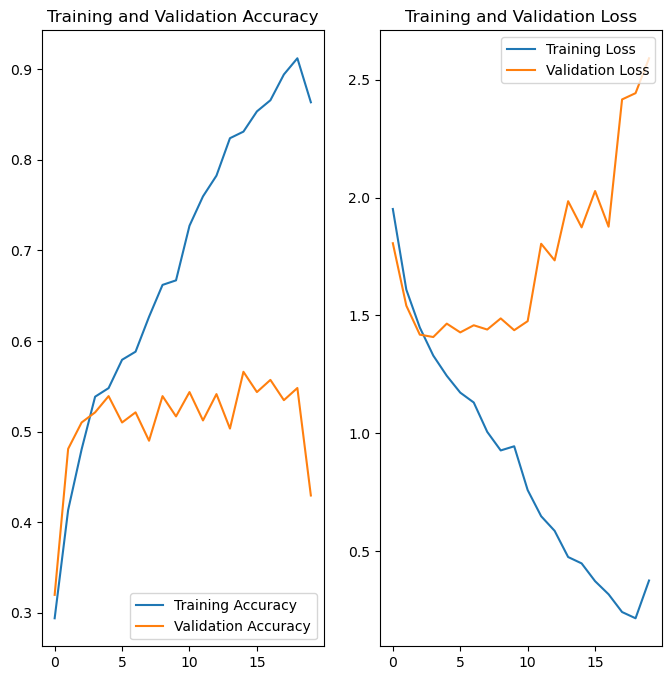

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Observation - Model is getting overfitted, model not getting actual patterns of validation set.

In [ ]:
#Data augmentation:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.25), # Rotating image with factor of 25% of 2pi [-25% * 2pi, 25% * 2pi]
  layers.RandomBrightness(0.3, value_range=(0, 255))
])

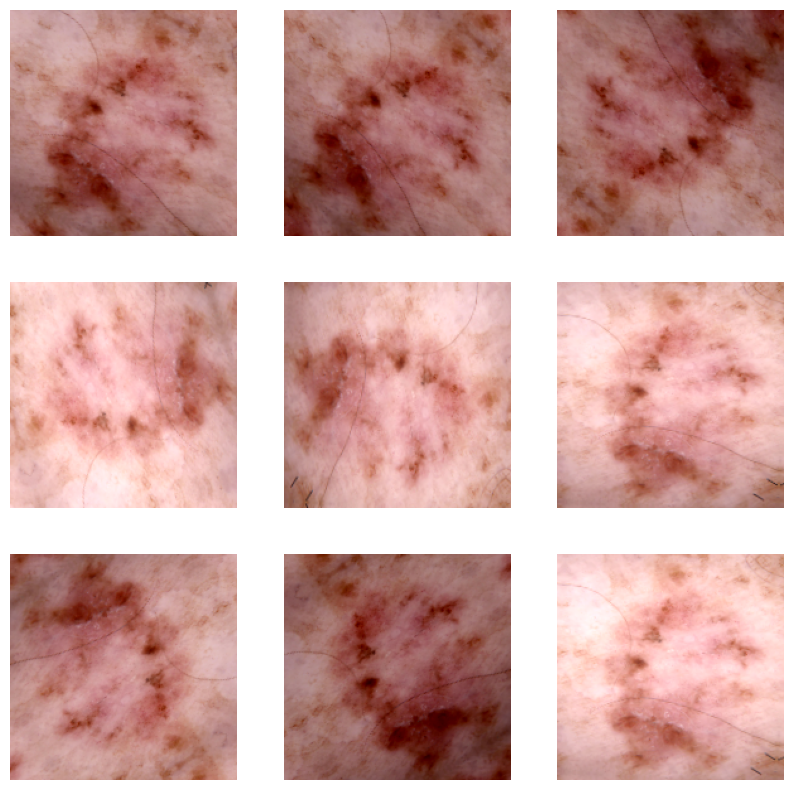

In [ ]:
# Visualizing data augmentation Strategy
image_batch, label_batch = next(iter(train_ds))
first_image = image_batch[0]
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(first_image)
  ax = plt.subplot(3, 3, i + 1)
  outimage = augmented_image.numpy()
  plt.imshow(outimage.astype('uint8') )
  plt.axis("off")

## Observation :-
This Model -1  accuracy is high for training and low for validation.
So the current model is overfitting for given data.

## Build Model 2

In [ ]:
num_classes = 9

model_v2 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  #layers.RandomFlip("horizontal_and_vertical"),  # Augmentation layer fplipping
  #layers.RandomRotation(0.25),  # Augmentation layer rotation
  tf.keras.layers.Conv2D(16, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_v2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Train the Model 2

In [ ]:
epochs = 20
history = model_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 789ms/step - accuracy: 0.2295 - loss: 2.1217 - val_accuracy: 0.3199 - val_loss: 1.8703
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - accuracy: 0.3929 - loss: 1.6798 - val_accuracy: 0.5011 - val_loss: 1.5059
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 785ms/step - accuracy: 0.5234 - loss: 1.3840 - val_accuracy: 0.4609 - val_loss: 1.4754
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 783ms/step - accuracy: 0.5469 - loss: 1.3017 - val_accuracy: 0.5101 - val_loss: 1.3487
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 787ms/step - accuracy: 0.5742 - loss: 1.1685 - val_accuracy: 0.5257 - val_loss: 1.3104
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 774ms/step - accuracy: 0.6438 - loss: 1.0010 - val_accuracy: 0.5749 - val_loss: 1.3344
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 771ms/step - accuracy: 0.6831 - loss: 0.8864 - val_accuracy: 0.4877 - val_loss: 1.5574
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - accuracy: 0.7448 - loss: 0.7196 - val_accu

### Visualise the Model 2 results

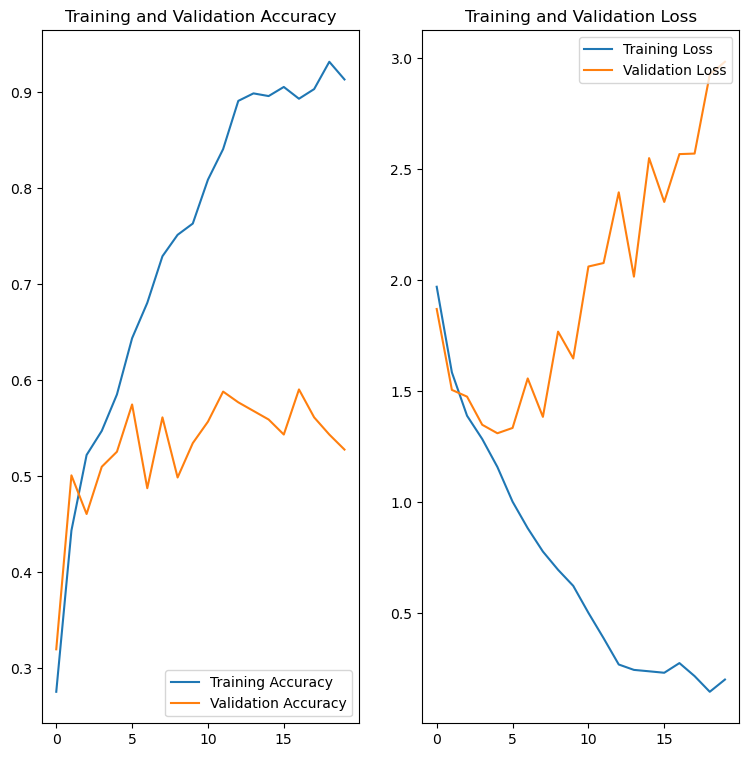

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

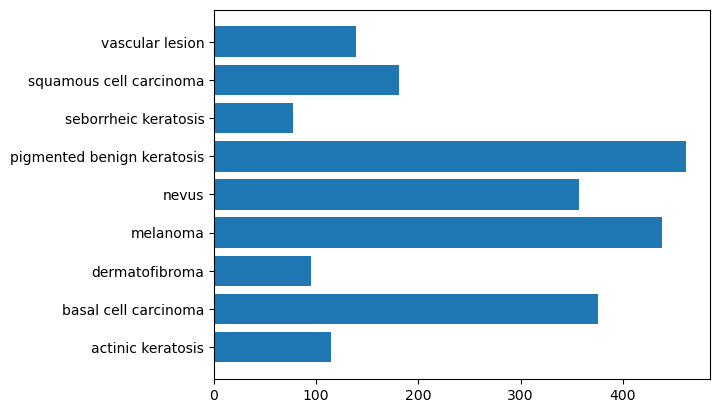

In [ ]:
#Analyze the data distribution for classes from training data to take necessary action.
num_images_classes = []
for class_name in class_names:
    num_images_class = len(os.listdir(os.path.join(Train_dp,class_name)))
    num_images_classes.append(num_images_class)
plt.barh(range(len(num_images_classes)), num_images_classes, tick_label=class_names)
plt.show()

### Observation :-
   From the plot shown above there is a significant imbalance in class distribution

   seborrheic keratosis' class has least number of training samples.
  
   pigmented benign keratosis' class dominating other classes in terms of number of training samples.


<BarContainer object of 9 artists>

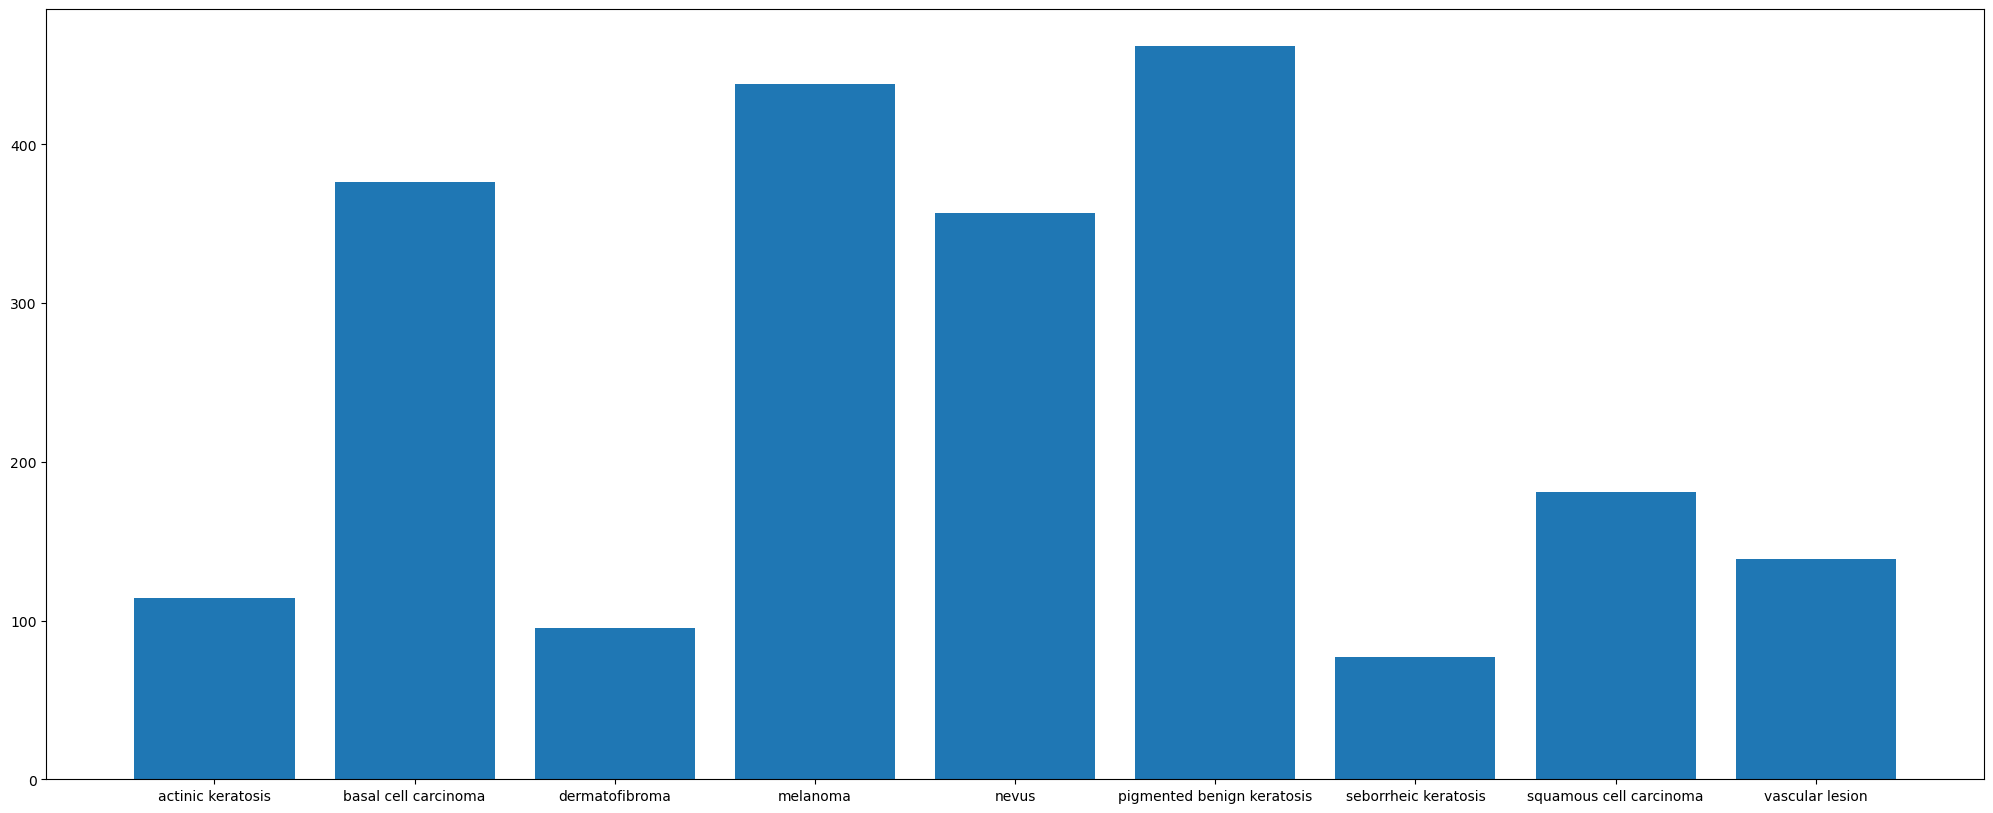

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Observation

 seborrheic keratosis, dermatofibroma, actinic keratosis least number of samples

 pigmented bengin keratosis,,melanoma has proportionate number of samples?

## Augumentation for Balancing the data

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22C349AF3B0>: 100%|██████████| 500/500 [00:04<00:00, 107.40 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22C3904A480>: 100%|██████████| 500/500 [00:06<00:00, 81.24 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22C349C21E0>: 100%|██████████| 500/500 [00:07<00:00, 71.14 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=963x629 at 0x22C34F2FB90>: 100%|██████████| 500/500 [00:35<00:00, 13.96 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2565x2000 at 0x22C390B85C0>: 100%|██████████| 500/500 [00:36<00:00, 13.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22C34F2F0B0>: 100%|██████████| 500/500 [00:06<00:00, 79.88 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22C34A6D100>: 100%|██████████| 500/500 [00:14<00:00, 33.80 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22B39F036E0>: 100%|██████████| 500/500 [00:06<00:00, 77.89 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22C34FCAD20>: 100%|██████████| 500/500 [00:06<00:00, 80.40 Samples/s]                  


### Data distribution

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,'*','./', '*.jpg'))]


In [ ]:
original_data = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(original_data.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [ ]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [ ]:
#Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_dp,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_dp,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Build Model_3


In [ ]:
num_classes = 9

model_v3 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),

  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),# non trainable mute at inference
  tf.keras.layers.RandomRotation(0.25), # non trainable mute at inference

  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_v3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_v3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │    63,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,518,185 (246.12 MB)

 Trainable params: 64,518,185 (246.12 MB)

 Non-trainable params: 0 (0.00 B)

### Train model3

In [ ]:
epochs = 50
history = model_v3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 155s 898ms/step - accuracy: 0.2673 - loss: 1.9685 - val_accuracy: 0.4291 - val_loss: 1.4205
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 144s 852ms/step - accuracy: 0.4247 - loss: 1.4838 - val_accuracy: 0.4581 - val_loss: 1.3872
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 145s 858ms/step - accuracy: 0.4621 - loss: 1.3824 - val_accuracy: 0.5219 - val_loss: 1.2434
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 143s 844ms/step - accuracy: 0.4912 - loss: 1.3129 - val_accuracy: 0.5019 - val_loss: 1.3218
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 146s 865ms/step - accuracy: 0.5114 - loss: 1.2630 - val_accuracy: 0.5375 - val_loss: 1.2826
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 147s 869ms/step - accuracy: 0.5291 - loss: 1.2053 - val_accuracy: 0.5583 - val_loss: 1.1608
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 841ms/step - accuracy: 0.5643 - loss: 1.1339 - val_accuracy: 0.5375 - val_loss: 1.3276
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 839ms/step - accuracy: 0.5490 -

### Visualize model 3 results

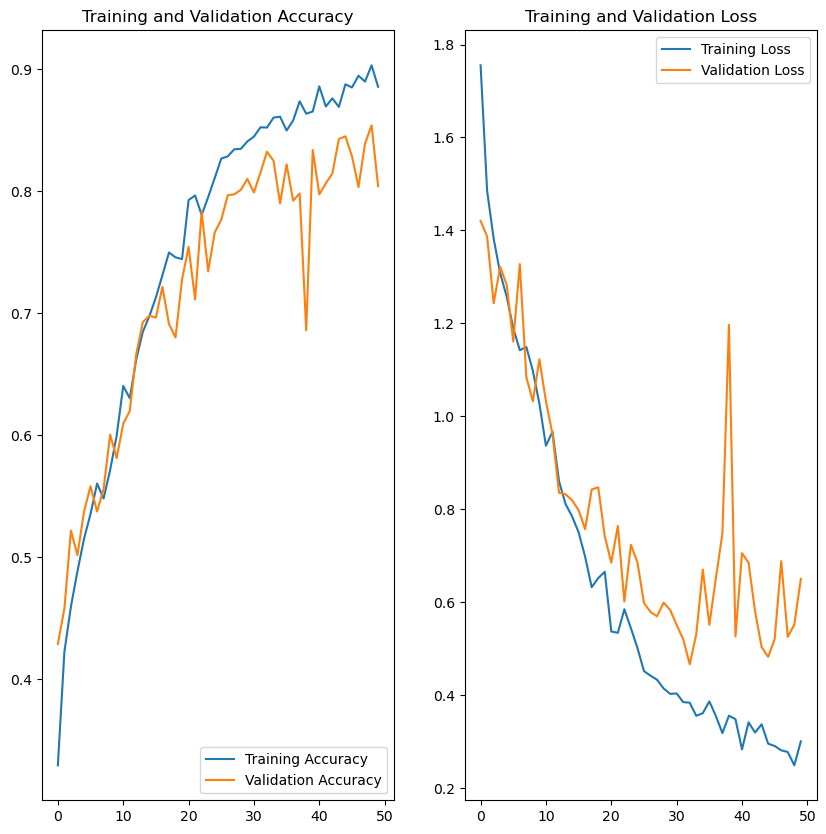

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




### Observation :
This Model seems to be unstable as validation accuracy going up and down for each epoch.

<BarContainer object of 9 artists>

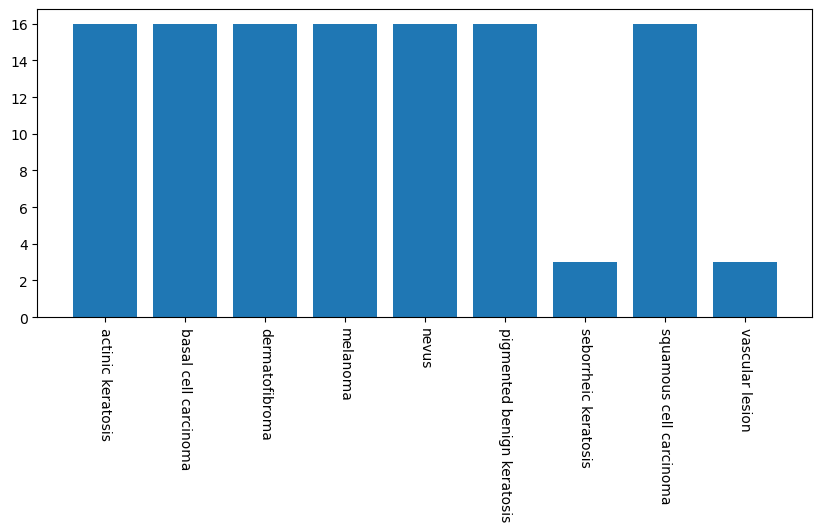

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_test.glob(i+'/*.jpg'))))
plt.figure(figsize=(10,4))
plt.xticks(rotation=270)
plt.bar(class_names,count)

# Build model_v4:


In [ ]:
num_classes = 9

model_v4 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),

  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),# non trainable mute at inference
  tf.keras.layers.RandomRotation(0.25), # non trainable mute at inference

  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=3),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model_v4.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_v4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2048)           │    29,493,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,570,537 (116.62 MB)

 Trainable params: 30,570,537 (116.62 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model 4:

In [ ]:
epochs = 50

history = model_v4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)## your training code

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 102s 583ms/step - accuracy: 0.1579 - loss: 2.4191 - val_accuracy: 0.1952 - val_loss: 2.0823
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 579ms/step - accuracy: 0.3071 - loss: 1.7988 - val_accuracy: 0.4336 - val_loss: 1.5483
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 568ms/step - accuracy: 0.4354 - loss: 1.4929 - val_accuracy: 0.4677 - val_loss: 1.4102
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 565ms/step - accuracy: 0.4558 - loss: 1.4252 - val_accuracy: 0.4929 - val_loss: 1.2797
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 95s 560ms/step - accuracy: 0.4698 - loss: 1.3293 - val_accuracy: 0.4907 - val_loss: 1.2832
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 577ms/step - accuracy: 0.5033 - loss: 1.2771 - val_accuracy: 0.5494 - val_loss: 1.1747
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 572ms/step - accuracy: 0.5218 - loss: 1.2688 - val_accuracy: 0.5375 - val_loss: 1.1553
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 589ms/step - accuracy: 0.5251 - loss:

In [ ]:
# Dataset for Testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Test_dp,
    labels='inferred',
    label_mode='int', #'categorical',
    color_mode='rgb',
    batch_size=1,
    image_size=(img_height, img_width),
    interpolation='bilinear',
    data_format= 'channels_last',
    verbose=True
)
predictions = []
labels =  []
for x, y in test_ds:
    idx_max = np.argmax(model_v4.predict(x))
    predictions.append(class_names[idx_max])
    labels.append(class_names[y.numpy()[0]])

Found 118 files belonging to 9 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(labels, predictions, labels=class_names)

array([[ 0,  0,  0,  1, 12,  2,  0,  1,  0],
       [ 0,  8,  0,  1,  0,  4,  0,  3,  0],
       [ 2,  4,  3,  6,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  4, 10,  0,  0,  0,  1],
       [ 0,  0,  0,  1, 14,  1,  0,  0,  0],
       [ 2,  1,  0,  0,  2,  9,  0,  2,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  1,  0],
       [ 1,  2,  0,  1,  3,  3,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3]], dtype=int64)

In [ ]:
metrics_cancer = metrics.classification_report(labels, predictions,labels=class_names ,output_dict=True)
metrics_cancer_df = pd.DataFrame(metrics_cancer).transpose()
#metrics_cancer_df.drop(["macro avg","weighted avg"], axis=1)
metrics_cancer_df


C:\Users\sriya\anaconda3\upgrade\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sriya\anaconda3\upgrade\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sriya\anaconda3\upgrade\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
actinic keratosis,0.000000,0.000000,0.000000,16.000000
basal cell carcinoma,0.500000,0.500000,0.500000,16.000000
dermatofibroma,1.000000,0.187500,0.315789,16.000000
melanoma,0.250000,0.250000,0.250000,16.000000
nevus,0.333333,0.875000,0.482759,16.000000
pigmented benign keratosis,0.473684,0.562500,0.514286,16.000000
seborrheic keratosis,0.000000,0.000000,0.000000,3.000000
squamous cell carcinoma,0.416667,0.312500,0.357143,16.000000
vascular lesion,0.600000,1.000000,0.750000,3.000000
accuracy,0.389831,0.389831,0.389831,0.389831


# Visualize the model results

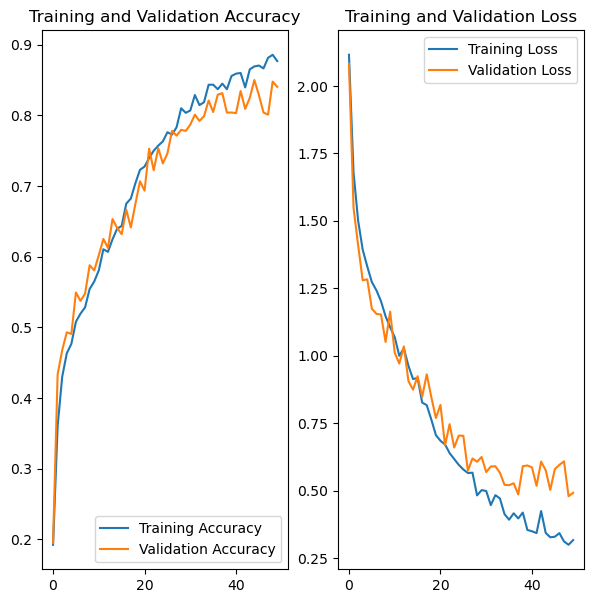

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ACCURACY='88.07%' VALLIDATION_ACCURACY='84.32%'

# Conclussion


Yes, the augmentor module really helped fine tune the model and get rid of Overfitting in our case.
#we are getting a good validatiion accuracry ~84%+ and 88%+ Training Accuracy. we can go with this model.